In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import numpy as np
import nltk
import pickle
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from fcmeans import FCM
from umap import UMAP
from sklearn.metrics import accuracy_score, f1_score, recall_score
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
clean_df = pd.read_csv("processed_data/cleaned_data.csv")
df = clean_df[clean_df['label'] == 1]
df.head()

,label,text
400,1,My husband and I visited the Fairmont Chicago ...
401,1,My wife and I booked a Deluxe Accessible Room ...
402,1,Quite simply the Hyatt Regency Chicago is the ...
403,1,Conrad Chicago it was 5:00 AM my plan just fle...
404,1,My girlfriends and I stayed at the Hyatt in Ch...


In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"<.*?>", '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)

df["clean_text"] = df["text"].astype(str).apply(clean_text)

C:\Users\User\AppData\Local\Temp\ipykernel_28420\1218097517.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clean_text"] = df["text"].astype(str).apply(clean_text)


In [8]:
model = SentenceTransformer('all-MiniLM-L6-v2')
X_embed = model.encode(df['text'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 671/671 [03:43<00:00,  3.00it/s]


In [9]:
umap = UMAP(n_components=20, min_dist=0.0, n_neighbors=10, random_state=42)
X_reduced = umap.fit_transform(X_embed)

c:\Users\User\anaconda3\envs\environment\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
true_labels = df['label'].values

In [11]:
def cluster_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    total = cm[row_ind, col_ind].sum()
    return total / len(y_true)


def remap_clusters(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    return [mapping[label] for label in y_pred]

In [12]:
n_clusters = 3

fcm = FCM(
    n_clusters=n_clusters,
    max_iter=1000,
    error=1e-5,
    m=2.0,
    random_state=42
)
fcm.fit(X_reduced)
pred_labels = fcm.predict(X_reduced)
df['cluster'] = pred_labels

aligned_preds = remap_clusters(true_labels, pred_labels)
acc = accuracy_score(true_labels, aligned_preds)
rec = recall_score(true_labels, aligned_preds, average='macro')
f1 = f1_score(true_labels, aligned_preds, average='macro')

print(f"=> Accuracy: {acc:.4f}")
print(f"=> Recall (macro): {rec:.4f}")
print(f"=> F1 Score (macro): {f1:.4f}")


=> Accuracy: 0.4145
=> Recall (macro): 0.1382
=> F1 Score (macro): 0.1954


C:\Users\User\AppData\Local\Temp\ipykernel_28420\2407419129.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = pred_labels
c:\Users\User\anaconda3\envs\environment\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


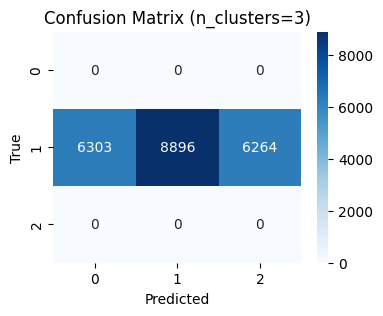

In [13]:
cm = confusion_matrix(true_labels, aligned_preds)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix (n_clusters={n_clusters})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [14]:
def get_top_words_by_cluster(df, cluster_col='cluster', text_col='clean_text', top_n=50):
    cluster_keywords = {}
    for cluster_id in sorted(df[cluster_col].unique()):
        # Get all text in the cluster
        cluster_texts = df[df[cluster_col] == cluster_id][text_col]

        # Tokenize and count word frequencies
        all_tokens = []
        for text in cluster_texts:
            all_tokens.extend(nltk.word_tokenize(text))

        word_freq = Counter(all_tokens)
        top_words = [word for word, freq in word_freq.most_common(top_n)]
        cluster_keywords[cluster_id] = top_words

    return cluster_keywords

top_words_per_cluster = get_top_words_by_cluster(df, top_n=50)

for cluster_id, keywords in top_words_per_cluster.items():
    print(f"\n------Cluster {cluster_id} Top 50 Words:------")
    print(", ".join(keywords))


------Cluster 0 Top 50 Words:------
book, story, read, good, character, movie, great, well, love, one, series, recommend, enjoyed, would, author, loved, liked, like, lot, first, reading, really, written, acting, next, developed, interesting, ending, anyone, time, way, bit, little, im, told, see, cant, forward, get, film, also, plot, wait, looking, fan, strong, honest, think, people, line

------Cluster 1 Top 50 Words:------
love, great, dog, one, would, hotel, room, little, like, good, bought, small, easy, get, recommend, also, product, toy, well, nice, year, made, chicago, size, use, piece, time, son, cat, plastic, put, quality, play, food, sturdy, bit, stay, set, lot, old, happy, two, im, price, thing, used, clean, keep, work, game

------Cluster 2 Top 50 Words:------
great, one, good, love, little, fit, would, bought, work, nice, small, size, use, quality, comfortable, like, well, light, im, recommend, product, also, easy, used, problem, bit, get, wear, material, happy, perfect, la

In [15]:
cluster_label_map = {
    0: "Scripted/Overwritten Fake Reviews",
    1: "Polished Positive Fake Reviews",
    2: "Template/Spam-Generated Fake Reviews"
}

df['cluster_label'] = df['cluster'].map(cluster_label_map)


C:\Users\User\AppData\Local\Temp\ipykernel_28420\6238132.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_label'] = df['cluster'].map(cluster_label_map)


In [ ]:
with open("fake_reivew_clustering/fcm_model.pkl", "wb") as f:
    pickle.dump(fcm, f)

# Save UMAP model
with open("fake_reivew_clustering/umap_model.pkl", "wb") as f:
    pickle.dump(umap, f)